In [1]:
# загрузка библиотек
import numpy as np
import nltk
import pickle
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\79251\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
# загрузка эмбеддингов
emb = np.load("russian_sentencenewlit_cbow_100_min_df=3_dict.npy", allow_pickle=True).item()

In [3]:
# построение траекторий
def text_to_trajectory(text, emb, n=3, d=4):
  tokens = word_tokenize(text)
  trajectory = []

  for t in ngrams(tokens, n):
    try:
      vectors = [emb[word][:d] for word in t]
      concat = np.concatenate(vectors)
      trajectory.append(concat)
    except KeyError as e:  # если нет какого-то слова в n-грамме, то надо пропускать всю n-грамму
      continue
  if trajectory:
      return np.stack(trajectory)
  else:
      return None

In [4]:
def build_trajectories(texts, emb):
    trajectories = []
    for text in texts:
        trajectory = text_to_trajectory(text, emb)
        if trajectory is not None:
            trajectories.append(trajectory)
    return trajectories

In [5]:
def load_texts(filename):
  with open(filename, encoding='utf-8') as f:
    lines = f.read().splitlines()
  return lines

In [6]:
# загрузка текстов
human = load_texts('human20.txt')
bot1 = load_texts('bot_bigbalaboba10.txt')
bot2 = load_texts('bot_biggpt210.txt')
bot3 = load_texts('bot_bigmgpt10.txt')
bot4 = load_texts('bot_newlstm10.txt')

In [7]:
trajectories_human = build_trajectories(human, emb)
trajectories_bot_newlstm = build_trajectories(bot4, emb)
trajectories_bot_bigbalaboba = build_trajectories(bot1, emb)
trajectories_bot_gpt2 = build_trajectories(bot2, emb)
trajectories_bot_biggpt = build_trajectories(bot3, emb)

In [8]:
data = {
    "human": trajectories_human,
    "bot1": trajectories_bot_bigbalaboba,
    "bot2": trajectories_bot_gpt2,
    "bot3": trajectories_bot_biggpt,
    "bot4": trajectories_bot_newlstm
}

with open("trajectories.pkl", "wb") as f:
    pickle.dump(data, f)

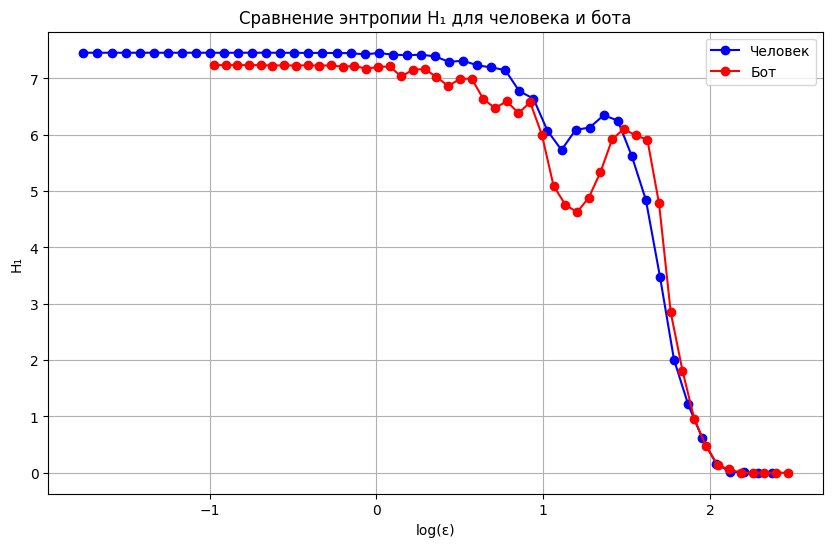

In [9]:
# для одного текста
import numpy as np
from scipy.spatial.distance import pdist
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# загружаем данные
with open("trajectories.pkl", "rb") as f:
    data = pickle.load(f)
    human_traj = data["human"][0]
    bot_traj = data["bot1"][0]

def get_H1_curve(traj, num_eps=50):
    distances = pdist(traj, 'euclidean')

    dist_min = np.min(distances[distances > 0])
    dist_max = np.max(distances)
    if dist_min <= 0:
        dist_min = 1e-10

    # логарифмический диапазон ε
    log_eps = np.linspace(np.log(dist_min) + 0.1, np.log(dist_max) - 0.1, num_eps)
    epsilons = np.exp(log_eps)

    # вычисляем H₁ для каждого ε
    H1_values = []
    for eps in epsilons:
        mins = traj.min(axis=0)
        norm_traj = (traj - mins) / eps
        bins = np.floor(norm_traj).astype(int)
        counts = Counter(tuple(row) for row in bins)
        probs = np.array(list(counts.values())) / len(traj)
        H1 = -np.sum(probs * np.log(probs + 1e-10))
        H1_values.append(H1)

    return log_eps, H1_values


log_eps_human, H1_human = get_H1_curve(human_traj)
log_eps_bot, H1_bot = get_H1_curve(bot_traj)

# построение графика
plt.figure(figsize=(10, 6))
plt.plot(log_eps_human, H1_human, 'o-', label='Человек', color='blue')
plt.plot(log_eps_bot, H1_bot, 'o-', label='Бот', color='red')
plt.xlabel('log(ε)')
plt.ylabel('H₁')
plt.title('Сравнение энтропии H₁ для человека и бота')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# нахождение размерности
from scipy.stats import linregress

def extract_linear_region(log_eps, H1_values, min_val=1.5, max_val=1.8):
    log_eps = np.array(log_eps)
    H1_values = np.array(H1_values)

    mask = (log_eps >= min_val) & (log_eps <= max_val)

    x = log_eps[mask].reshape(-1, 1)
    y = H1_values[mask]

    return x, y

x_h, y_h = extract_linear_region(log_eps_human, H1_human)
x_b, y_b = extract_linear_region(log_eps_bot, H1_bot)

model_h = LinearRegression().fit(x_h, y_h)
slope_h = model_h.coef_[0]
D1_h = 1 / np.sqrt(1 + slope_h**2)
print(f"Размерность D₁ (человек): {D1_h:.4f}")

model_b = LinearRegression().fit(x_b, y_b)
slope_b = model_b.coef_[0]
D1_b = 1 / np.sqrt(1 + slope_b**2)
print(f"Размерность D₁ (бот): {D1_b:.4f}")

Размерность D₁ (человек): 0.0690
Размерность D₁ (бот): 0.0664


In [11]:
import numpy as np
import pickle
import pandas as pd
from scipy.spatial.distance import pdist
from collections import Counter
from scipy.stats import linregress

# === Параметры линейного участка ===
LINEAR_REGION_MIN = 1.5
LINEAR_REGION_MAX = 1.8

# === Функция: построение H1-кривой ===
def get_H1_curve(traj, num_eps=50):
    distances = pdist(traj, 'euclidean')
    dist_min = np.min(distances[distances > 0])
    dist_max = np.max(distances)
    if dist_min <= 0:
        dist_min = 1e-10

    log_eps = np.linspace(np.log(dist_min) + 0.1, np.log(dist_max) - 0.1, num_eps)
    epsilons = np.exp(log_eps)

    H1_values = []
    for eps in epsilons:
        mins = traj.min(axis=0)
        norm_traj = (traj - mins) / eps
        bins = np.floor(norm_traj).astype(int)
        counts = Counter(tuple(row) for row in bins)
        probs = np.array(list(counts.values())) / len(traj)
        H1 = -np.sum(probs * np.log(probs + 1e-10))
        H1_values.append(H1)

    return log_eps, H1_values

# === Функция: извлечение D1 из фиксированного линейного участка ===
def extract_dimension_fixed(log_eps, H1_values, min_val=LINEAR_REGION_MIN, max_val=LINEAR_REGION_MAX):
    log_eps = np.array(log_eps)
    H1_values = np.array(H1_values)
    mask = (log_eps >= min_val) & (log_eps <= max_val)
    if np.sum(mask) < 2:
        return None
    x = log_eps[mask]
    y = H1_values[mask]
    slope, _, _, _, _ = linregress(x, y)
    D1 = 1 / np.sqrt(1 + slope**2)
    return D1

# === Функция: обработка всех траекторий для одной группы ===
def compute_dimensions(trajectories):
    dimensions = []
    for traj in trajectories:
        log_eps, H1_values = get_H1_curve(traj)
        D1 = extract_dimension_fixed(log_eps, H1_values)
        if D1 is not None:
            dimensions.append(D1)
    return dimensions


In [15]:
import numpy as np
import pickle
import pandas as pd
from scipy.spatial.distance import pdist
from collections import Counter
from scipy.stats import linregress

# === Параметры линейного участка ===
LINEAR_REGION_MIN = 1.5
LINEAR_REGION_MAX = 1.8

def get_H1_curve(traj, num_eps=50):
    MAX_POINTS = 1000
    if len(traj) < 2:
        return None, None
    if len(traj) > MAX_POINTS:
        indices = np.linspace(0, len(traj) - 1, MAX_POINTS).astype(int)
        traj = traj[indices]

    distances = pdist(traj, 'euclidean')
    nonzero_distances = distances[distances > 0]
    if len(nonzero_distances) == 0:
        return None, None

    dist_min = np.min(nonzero_distances)
    dist_max = np.max(distances)
    if dist_min <= 0 or dist_max <= dist_min:
        return None, None

    log_eps = np.linspace(np.log(dist_min) + 0.1, np.log(dist_max) - 0.1, num_eps)
    if not np.all(np.isfinite(log_eps)):
        return None, None

    epsilons = np.exp(log_eps)
    H1_values = []

    for eps in epsilons:
        mins = traj.min(axis=0)
        norm_traj = (traj - mins) / eps
        bins = np.floor(norm_traj).astype(int)
        counts = Counter(tuple(row) for row in bins)
        probs = np.array(list(counts.values())) / len(traj)
        H1 = -np.sum(probs * np.log(probs + 1e-10))
        H1_values.append(H1)

    return log_eps, H1_values



# === Функция: извлечение D1 из фиксированного линейного участка ===
def extract_dimension_fixed(log_eps, H1_values, min_val=LINEAR_REGION_MIN, max_val=LINEAR_REGION_MAX):
    log_eps = np.array(log_eps)
    H1_values = np.array(H1_values)
    mask = (log_eps >= min_val) & (log_eps <= max_val)
    if np.sum(mask) < 2:
        return None
    x = log_eps[mask]
    y = H1_values[mask]
    slope, _, _, _, _ = linregress(x, y)
    D1 = 1 / np.sqrt(1 + slope**2)
    return D1

# === Функция: обработка всех траекторий для одной группы ===
def compute_dimensions(trajectories):
    dimensions = []
    for traj in trajectories:
        log_eps, H1_values = get_H1_curve(traj)
        D1 = extract_dimension_fixed(log_eps, H1_values)
        if D1 is not None:
            dimensions.append(D1)
    return dimensions

In [17]:
import numpy as np
import pickle
import pandas as pd
from scipy.spatial.distance import pdist
from collections import Counter
from scipy.stats import linregress


LINEAR_REGION_MIN = 1.5
LINEAR_REGION_MAX = 1.8

def get_H1_curve(traj, num_eps=50):
    MAX_POINTS = 1000
    if len(traj) < 2:
        return None, None
    if len(traj) > MAX_POINTS:
        indices = np.linspace(0, len(traj) - 1, MAX_POINTS).astype(int)
        traj = traj[indices]

    distances = pdist(traj, 'euclidean')
    nonzero_distances = distances[distances > 0]
    if len(nonzero_distances) == 0:
        return None, None

    dist_min = np.min(nonzero_distances)
    dist_max = np.max(distances)
    if dist_min <= 0 or dist_max <= dist_min:
        return None, None

    log_eps = np.linspace(np.log(dist_min) + 0.1, np.log(dist_max) - 0.1, num_eps)
    if not np.all(np.isfinite(log_eps)):
        return None, None

    epsilons = np.exp(log_eps)
    H1_values = []

    for eps in epsilons:
        mins = traj.min(axis=0)
        norm_traj = (traj - mins) / eps
        bins = np.floor(norm_traj).astype(int)
        counts = Counter(tuple(row) for row in bins)
        probs = np.array(list(counts.values())) / len(traj)
        H1 = -np.sum(probs * np.log(probs + 1e-10))
        H1_values.append(H1)

    return log_eps, H1_values



# нахождение размерности на заданном линейном участке
def extract_dimension_fixed(log_eps, H1_values, min_val=LINEAR_REGION_MIN, max_val=LINEAR_REGION_MAX):
    log_eps = np.array(log_eps)
    H1_values = np.array(H1_values)
    mask = (log_eps >= min_val) & (log_eps <= max_val)
    if np.sum(mask) < 2:
        return None
    x = log_eps[mask]
    y = H1_values[mask]
    slope, _, _, _, _ = linregress(x, y)
    D1 = 1 / np.sqrt(1 + slope**2)
    return D1


def compute_dimensions(trajectories):
    dimensions = []
    for traj in trajectories:
        log_eps, H1_values = get_H1_curve(traj)
        if log_eps is None or H1_values is None:
            continue  # пропускаем невалидные траектории
        D1 = extract_dimension_fixed(log_eps, H1_values)
        if D1 is not None:
            dimensions.append(D1)
    return dimensions

In [18]:
with open("trajectories.pkl", "rb") as f:
    data = pickle.load(f)

# обработка всех траекторий и сохранение в csv
for key in data:
    dims = compute_dimensions(data[key])
    label = 1 if key == "human" else 0
    df = pd.DataFrame({
        "D1": dims,
        "label": [label] * len(dims)
    })
    filename = f"dimensions_{key}.csv"
    df.to_csv(filename, index=False)